### Assesment 2 - Computer Vision (Image Classification)
- This assesment purpose is to do image classification of building cracking/not cracking classification
- The dataset used have 40000 images with 20000 each for `[Negative]` and `[Positive]` respectively.
- The model is developed using deep learning algorithm.

In [1]:
# 1. Setup - Import Packages
import os
import cv2
import imghdr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report


In [2]:
#2. Get the dataset
# P/S: This cell is to download the dataset, has to manually unzip and unrar the file.
DATA_FOLDER_NAME = 'Concrete Crack Images for Classification'
_URL = 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip'
path_to_zip = tf.keras.utils.get_file(f'{DATA_FOLDER_NAME}.zip', origin=_URL, extract=True)


In [3]:
# (A) This dataset is already downloaded and its in zip format. It will unzip the dataset and access its content.
DATA_FOLDER_NAME = 'Concrete Crack Images for Classification'
path_to_zip = os.path.join(os.getcwd(), f'{DATA_FOLDER_NAME}.zip')
PATH = os.path.join(os.path.dirname(path_to_zip), DATA_FOLDER_NAME)

# Check if the ZIP file exists
if os.path.exists(path_to_zip):
    # Extract the contents of the ZIP file to the parent folder
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(path_to_zip))

    print(f"Successfully extracted the contents to: {os.path.dirname(path_to_zip)}")
else:
    print(f"ZIP file not found at: {path_to_zip}")

Successfully extracted the contents to: c:\Users\nazmi\Downloads\SHRDC\Capstone Project\Assesment_2


In [4]:
# The image extensions that we would like to work with.
image_exts = ['jpeg','jpg','bmp','png']
print(os.listdir(PATH))

['Negative', 'Positive']


In [ ]:
# To check whether the file is in the right extensions 
# P/S: can skip this part if you're confident with the dataset since this function will run for minutes
for image_class in os.listdir(DATA_FOLDER_NAME):
    for image in os.listdir(os.path.join(DATA_FOLDER_NAME, image_class)):
        image_path = os.path.join(DATA_FOLDER_NAME, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in extension list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

In [5]:
#3. Load Data
data = keras.utils.image_dataset_from_directory(DATA_FOLDER_NAME)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 40000 files belonging to 2 classes.


In [6]:
# Checking the batches shape
print(batch[0].shape)
# 32 images, each image has height: 256, width: 256, channel: 3 (rgb)

(32, 256, 256, 3)


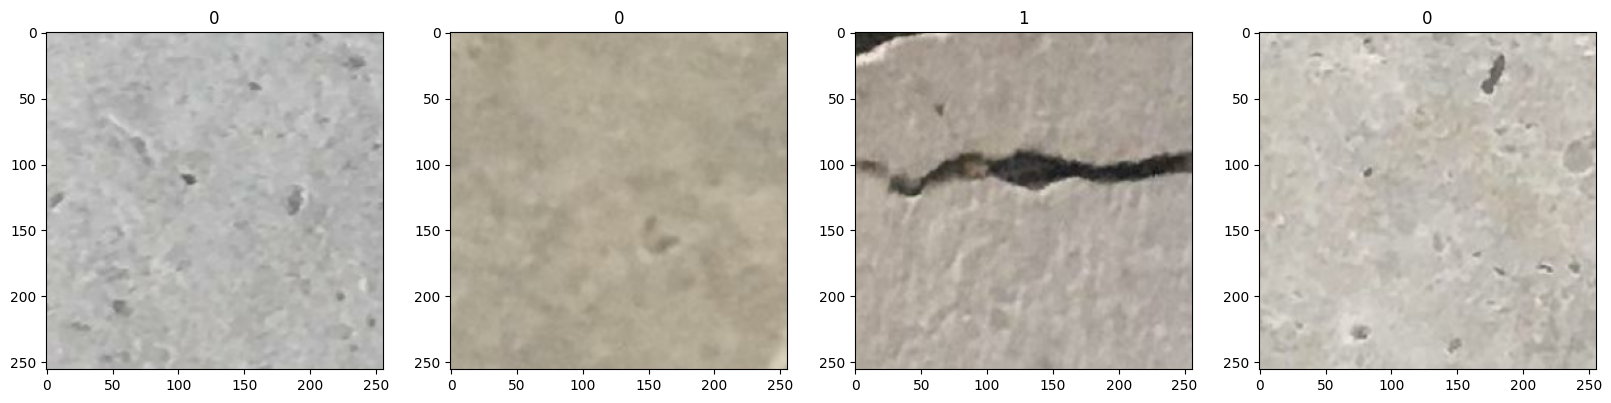

In [7]:
# Plot 4 sample images from the first batch.
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

- As confirmed from above, the label/class 0 is considered `Not Crack` `[Positive]`
- While the label/class 1 is considered  `Crack` `[Negative]`

In [8]:
# Rescale the image
data = data.map(lambda x, y: (x/255, y))

In [9]:
#5. Splitting Data
train_size = int(len(data) * 0.7)

# val data: used during training, to tune parameters like hidden layers
val_size = int(len(data) * 0.2)

# test data: used after training, to see performance of model
test_size = int(len(data) * 0.1)

In [10]:
# Using the `tf.data.Dataset.take()` to take based on splitting sizes, `tf.data.Dataset.skip()` for skipping the ones that already taken for training
train = data.take(train_size)
val = data.take(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [11]:
#6. Build the Model
model = Sequential()
model.add(Conv2D(16, (3,3,), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
#12. Prepare the callback functions for model training
early_stopping = EarlyStopping(patience=2)
logpath = os.path.join('tensorboard_log',datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = TensorBoard(logpath)
optimizer = Adam(learning_rate=0.001)

In [13]:
model.compile(optimizer=optimizer, loss=binary_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

In [14]:
#7. Train model
history = model.fit(train, epochs=20, validation_data=val, callbacks=[early_stopping, tb])

Epoch 1/20
875/875 [==============================] - 64s 67ms/step - loss: 0.1343 - accuracy: 0.9493 - val_loss: 0.0961 - val_accuracy: 0.9700
Epoch 2/20
875/875 [==============================] - 59s 68ms/step - loss: 0.0479 - accuracy: 0.9860 - val_loss: 0.1281 - val_accuracy: 0.9797
Epoch 3/20
875/875 [==============================] - 59s 68ms/step - loss: 0.0444 - accuracy: 0.9872 - val_loss: 0.0285 - val_accuracy: 0.9910
Epoch 4/20
875/875 [==============================] - 62s 71ms/step - loss: 0.0285 - accuracy: 0.9917 - val_loss: 0.0458 - val_accuracy: 0.9840
Epoch 5/20
875/875 [==============================] - 60s 69ms/step - loss: 0.0270 - accuracy: 0.9913 - val_loss: 0.0495 - val_accuracy: 0.9865


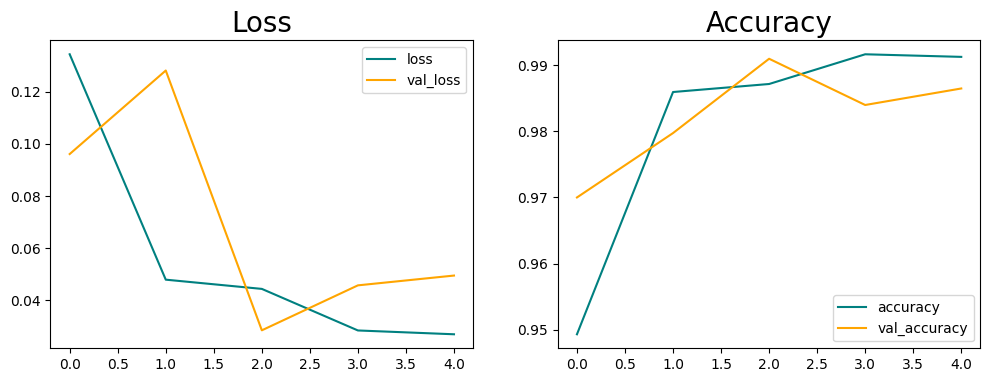

In [15]:
#8. Plot Graph Loss and Accuracy
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot Loss
axes[0].plot(history.history['loss'], color='teal', label='loss')
axes[0].plot(history.history['val_loss'], color='orange', label='val_loss')
axes[0].set_title('Loss', fontsize=20)
axes[0].legend()

# Plot Accuracy
axes[1].plot(history.history['accuracy'], color='teal', label='accuracy')
axes[1].plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
axes[1].set_title('Accuracy', fontsize=20)
axes[1].legend()

plt.show()

In [16]:
#9. Evaluate
#(A) Classification Report
y_pred = model.predict(val)
# y_pred is probability, needs to convert to category
# probability less than 0.5 is class 0 [Positive]
# probability more than 0.5 is class 1 [Negative]
y_pred = np.where(y_pred > 0.5, 1, 0)
y_test = tf.concat([y for x,y in val], axis = 0)

# print Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.52      0.51      4000
           1       0.50      0.49      0.50      4000

    accuracy                           0.50      8000
   macro avg       0.50      0.50      0.50      8000
weighted avg       0.50      0.50      0.50      8000



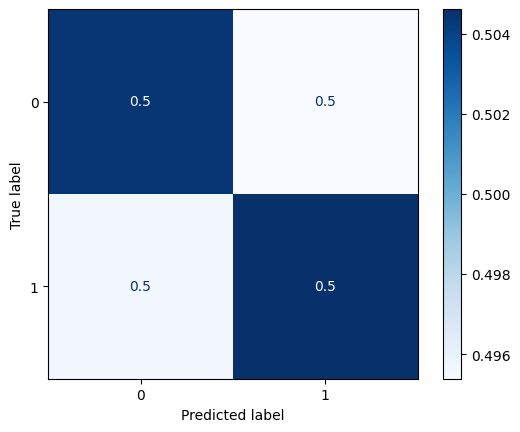

In [17]:
#(B) Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='pred')
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap=plt.cm.Blues)
plt.show()

In [18]:
#10. Test Model
# Function to Predict Crack or Not
def predict_crack(image_path):
    # Read image
    img = cv2.imread(image_path)
    
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Display original image
    axes[0].set_title('Original Image', fontsize=10)
    axes[0].imshow(img)

    # Resize image
    resize = tf.image.resize(img, (256, 256))

    # Display resized image
    axes[1].set_title('Scaled Image', fontsize=10)
    axes[1].imshow(resize.numpy().astype(int))
    plt.show()
    
    # Make prediction
    y_pred = model.predict(np.expand_dims(resize / 255, 0))
    
    # Display prediction result
    if y_pred > 0.5:
        print(y_pred)
        print('Predicted class is Crack')
    else:
        print(y_pred)
        print('Predicted class is Not Crack')

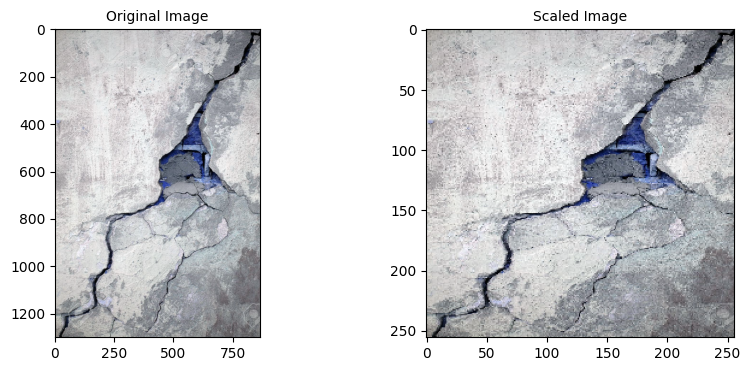

[[0.9999218]]
Predicted class is Crack


In [19]:
predict_crack(r'images\crack_image1.jpg')

In [20]:
#11. Save Model
model.save(os.path.join('models','crack_classify.h5'))

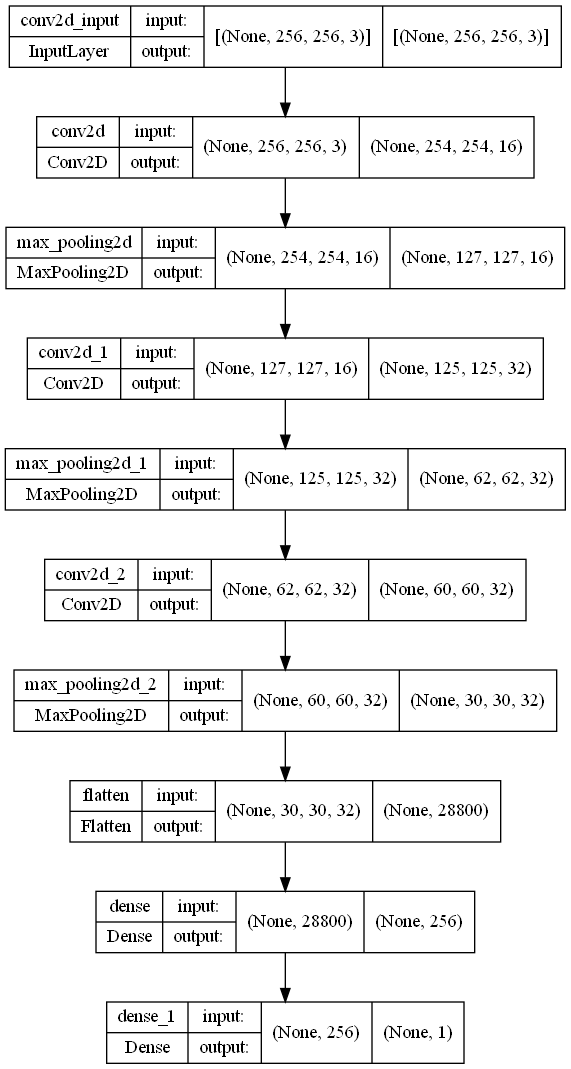

In [21]:
#12.Save the Model Architecture
architecture_path = os.path.join('models', 'model_architecture.png')
tf.keras.utils.plot_model(model, to_file=architecture_path, show_shapes=True, show_layer_names=True)